# Project ABS
The goal of this notebook will be to explore data compiled from the Australian Bureau of Statistics (ABS) compiled as part of their [AUSSTATS](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1410.02013-18?OpenDocument) documentation, looking at trends across a wide variety of "key measures" by geographical region within Australia.

Preliminarily I am interested in exploring the interesting factoids regarding solar panel installations which have piqued my curiousity, and leveraging these for delivering value- creating insights.

Note all files were originally ".xls" format, and have had incredibly minor alterations as follows:
* Removing "branding" and "page header" rows (rows 1-5 in source document)
* Removing "Copyright" and empty "footer" columns at the end of the dataset
* Consolidating all the details outlined in the column headers into 1 header per column (removing merged formatting and cross filling for empty cells)
* Saving each document as .csv

All files are based on the ASGS (Australian Statistical Geography Standard) location methodology. There is potential of further exploration based on documents located [here](https://www.abs.gov.au/AUSSTATS/abs@.nsf/DetailsPage/1270.0.55.003July%202011?OpenDocument).

### CRISP-DM Process
1. Business Understanding
2. Data Understanding
3. Prepare Data
4. Data Modeling
5. Evaluate the Results
6. Deploy

## Main Questions
The main questions I would like to explore are:
1. What are the main indicators of a region having an increased propensity to have solar panels installed?
2. For these identified features, how do changes in the feature impact changes in solar panels installed?
3. How have solar installations changed over time when using these features as categories?
4. Based on the above, what insights would I share with key stakeholders to the solar industry (energy companies, governments, etc.) when considering future strategies?

# Imports Section

Note: This section also contains a significant amount of data cleaning and explortation functions I created, feeding into the "Prepare" and "Understand" steps within the CRISP-DM process.

In [1]:
# Declare Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
import os
from textwrap import wrap
import operator

solar = 'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.'

In [2]:
# Set a variable for current notebook's path for various loading/saving mechanisms
nb_path = os.getcwd()

In [3]:
# Create list of all files in CSV directory
files = []

for (dirpath, dirnames, filenames) in os.walk('{}\CSV'.format(nb_path)):
    files.extend(filenames)
    break

for f in files:
    if f[-4:] != '.csv':
        files.remove(f)

In [4]:
# Load all the files into a single df
df = pd.read_csv('{}\CSV\{}'.format(nb_path, files[0]), na_values='-', thousands=',')

for file in range(1,len(files)):
    df_temp = pd.read_csv('{}\CSV\{}'.format(nb_path, files[file]), na_values='-', thousands=',')
    df = pd.merge(df, df_temp, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

C:\Users\kempbri\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
# Load in latitude and longitude data
df_temp = pd.read_csv('{}\latlng.csv'.format(nb_path), na_values='-', thousands=',')
df_temp.rename(columns = {df_temp.columns[0] : 'LABEL'}, inplace=True)
df = pd.merge(df, df_temp, how='inner', left_on='LABEL', right_on='LABEL')

df.head()

,CODE,LABEL,YEAR,NUMBER OF BUSINESSES Number of non-employing businesses no.,NUMBER OF BUSINESSES 1-4 employees no.,NUMBER OF BUSINESSES 5-19 employees no.,NUMBER OF BUSINESSES 20 or more employees no.,NUMBER OF BUSINESSES Total number of businesses no.,BUSINESS ENTRIES Number of non-employing business entries no.,BUSINESS ENTRIES 1-4 employees no.,...,RELIGIOUS AFFILIATION Judaism %,RELIGIOUS AFFILIATION Other Religions %,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %",RELIGIOUS AFFILIATION Inadequately described or not stated %,AUSTRALIAN CITIZENSHIP Australian citizen %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,AUSTRALIAN CITIZENSHIP Australian Citizenship - Not stated %,SPEAKS A LANGUAGE OTHER THAN ENGLISH AT HOME Proportion of total population %,lat,long
0,10102,Queanbeyan,2016,2730.0,1331.0,450.0,85.0,4596.0,388.0,173.0,...,0.1,1.1,29.2,10.0,87.0,5.4,7.7,12.0,-35.352466,149.233725
1,101021009,Queanbeyan,2016,402.0,193.0,89.0,27.0,712.0,75.0,32.0,...,0.1,2.1,28.5,10.5,80.6,11.2,8.2,21.2,-35.352466,149.233725
2,10202,Wyong,2016,4573.0,3006.0,895.0,178.0,8657.0,781.0,540.0,...,0.1,0.4,26.6,8.1,89.7,4.2,6.2,4.8,-33.285641,151.425306
3,102021057,Wyong,2016,322.0,193.0,85.0,23.0,631.0,40.0,34.0,...,0.1,0.7,28.6,9.4,86.1,6.3,7.6,8.2,-33.285641,151.425306
4,10301,Bathurst,2016,2369.0,1123.0,412.0,79.0,3991.0,284.0,144.0,...,NaN,0.4,22.6,11.7,86.9,3.4,9.7,4.0,-33.474707,149.641320


In [6]:
# We are only interested in the very bottom level data (i.e. township, not state). 
# Given this bottom level has "CODE" of 9 characters: remove all rows with code length < 9
# Using Len function to evaluate as a string to evaluate because the codes are mixed type.
def remove_aggregation(df):
    df.drop(df[df['CODE'].astype(str).map(len) <= 8].index, inplace=True)
    return df

In [7]:
df.reset_index(inplace=True)

df = remove_aggregation(df)

df.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)

df['Solar Per Household'] = df[solar]/df['HOUSEHOLDS BY TYPE Total households no.']

In [8]:
def clean_data(df, y_column, fill_mean_subset = None):
    '''
    A function to clean a dataframe and return X & y values for further processing. 
    Rows are removed where NaNs are present in response vector records.
    NaN values for all other features are filled with the mean of the feature.
    
    INPUT
    df - pandas dataframe 
    y_column - String. Name of column to be used as the response vector
    fill_mean_subset - String, column name. Allows the input of a column to "subset" when first completing
                        imputing missing numerical values with a series mean. E.g. if there is a categorical 
                        field of "year", allows imputing of null values with the mean of each year, rather 
                        than the mean of the overall series.  
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    '''    
    # Remove duplicate columns
    drop_cols = []
    check_cols = df.columns.tolist()
    check_cols.sort()
    w_end = len(check_cols)
    i = 0
    
    # Cycle through each column name
    while i < w_end:
        # assign a Check variable the the column name as a string
        # that name string should only include characters up to 1 character after the final space
        # e.g. "* %" or "* n"
        check_str = check_cols[i]
        check_str = check_str[:(check_str.rfind(" ")+2)]
        
        for col in check_cols[(i+1):]:
            # look forward in the list of column names for any other items matching CheckString & "*"
            # add any matches to a list to drop, drop from the "check" list as well so make further searches more efficient.
            # I'm almost certain there is a more efficient way to do this list/dict-wise
            if col.startswith(check_str):
                drop_cols.append(col)
                check_cols.remove(col)
                w_end -= 1
        i += 1  
    
    df.drop(drop_cols, axis = 1, inplace=True)
    
    # Drop rows with missing response values
    df = df.dropna(subset=[y_column], axis=0)
    y = df[y_column]
    df = df.dropna(how = 'all', axis = 1)
    #Drop response column
    df = df.drop(y_column, axis=1)
    
    # Fill numeric columns with the mean    
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    # First, fill with the mean of the subset based on given category
    if fill_mean_subset != None:
        index_reset = False
        index_names = list(df.index.names)
        
        # Filtering sucks with multi-indexing so temporarily reset the indexes for this action
        if fill_mean_subset in index_names:
            index_reset = True
            df.reset_index(inplace=True)

        #Check if subset variable is an index item
        for subset_item in df[fill_mean_subset].unique().tolist():
            for col in num_vars:
                subset_mean = df[df[fill_mean_subset] == subset_item][col].mean() 
                df.loc[(df[fill_mean_subset] == subset_item) & (df[col].isnull()), col] = subset_mean
        
        if index_reset:
            df.set_index(index_names, inplace=True)

    # For any remaining nulls, fill with the mean of the overall series
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # OHE the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    # Fill OHE NaNs with 0
    # Get list of columns after OHE that were not in the "numeric" list from earlier, using set function for speed.
    cat_vars = list(set(df.columns.tolist()) - set(num_vars.tolist()))
    for var in cat_vars:
        df[var].fillna(0, inplace=True)
    
    X = df
    return X, y

In [9]:
def sort_series_abs(S):
    'Takes a pandas Series object and returns the series sorted by absolute value'
    temp_df = pd.DataFrame(S)
    temp_df['abs'] = temp_df.iloc[:,0].abs()
    temp_df.sort_values('abs', ascending = False, inplace = True)
    return temp_df.iloc[:,0]

In [10]:
def plot_bar_comparisons(df, num_cols):
    '''
    Takes a dataframe object and plots each row as a bar chart using the index as the 
    chart title and the other columns as X-axis labels, within a 5x(n/5) subplot frame
    df: dataframe object with values from which you want a chart of each row
    num_cols: the number of charts per output row
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    fig, axs = plt.subplots(nrows = int(rows/num_cols + rows%num_cols), ncols = num_cols, sharey = True,
                           figsize=(15,int(rows*0.66)))
    i=1
    for row in axs:
        for ax in row:
            if i <= rows:
                sns.barplot(data = df.iloc[i-1:i,:], ax = ax)
                ax.title.set_text(df.index[i-1])
            else:
                ax.axis('off')
            i += 1
    plt.tight_layout()    
    plt.show()

In [12]:
def feature_plot(importances, X_train, n_features):
    
    # Display the n most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    values = importances[indices][:n_features]
    
    columns = [ '\n'.join(wrap(c, 20)) for c in columns ]
    
    # Create the plot
    fig = plt.figure(figsize = (9,n_features))
    plt.title("Normalized Weights for {} Most Predictive Features".format(n_features), fontsize = 16)
    plt.bar(np.arange(n_features), values, width = 0.6, align="center", color = '#00A000', 
          label = "Feature Weight")
    plt.bar(np.arange(n_features) - 0.3, np.cumsum(values), width = 0.2, align = "center", color = '#00A0A0', 
          label = "Cumulative Feature Weight")
    plt.xticks(np.arange(n_features), columns, rotation = 'vertical')
    #plt.xlim((-0.5, 4.5))
    plt.ylabel("Weight", fontsize = 12)
    #plt.xlabel("Feature", fontsize = 12)
    
    plt.legend(loc = 'upper right')
    plt.tight_layout()
    plt.show()  

In [13]:
def feature_plot_h(importances, X_train, n_features):
    
    # Identify the n most important features
    indices = np.argsort(importances)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    values = importances[indices][:n_features]
    
    columns = [ '\n'.join(wrap(c, 20)) for c in columns ]
    
    # Create the plot
    fig = plt.figure(figsize = (9,n_features))
    plt.title("Normalized Weights for {} Most Predictive Features".format(n_features), fontsize = 16)
    plt.barh(np.arange(n_features), values, height = 0.6, align="center", color = '#00A000', 
          label = "Feature Weight")
    plt.barh(np.arange(n_features) - 0.3, np.cumsum(values), height = 0.2, align = "center", color = '#00A0A0', 
          label = "Cumulative Feature Weight")
    plt.yticks(np.arange(n_features), columns)
    plt.xlabel("Weight", fontsize = 12)
    
    plt.legend(loc = 'upper right')
    
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()  

In [95]:
# For fun exploration, let's just run a histogram over everything!
def histo_plots(df, num_cols):
    '''
    Takes a dataframe object and plots each column as a histogram chart using the feature title as the 
    chart title and the other columns as X-axis labels, within an n*(len/n) subplot frame
    df: DataFrame object with values from which you want a chart of each row
    num_cols: Integer. the number of charts per output row.
    '''
    rows = df.shape[0]
    columns = df.shape[1]
    plot_rows = (int(columns/num_cols) + ((columns%num_cols)!=0))
    fig, axs = plt.subplots(nrows = plot_rows, 
                            ncols = num_cols, sharey = False, figsize=(15,columns))
    nlines = 1
    
    if plot_rows > 1:
        for i in range(num_cols * plot_rows):
            ax_col = int(i/num_cols)
            ax_row = i%num_cols

            if i < columns:
                try:
                    df.iloc[:,i].dropna().plot.hist(ax = axs[ax_col, ax_row])
                    axs[ax_col, ax_row].set_title("\n".join(wrap(str(df.columns[i]), int(100/num_cols))))
                    nlines = max(nlines,axs[ax_col, ax_row].get_title().count('\n'))

                except:
                    axs[ax_col, ax_row].set_title("\n".join(wrap(df.columns[i], 100/num_cols)))
                    axs[ax_col, ax_row].axis('off')
            else:
                axs[ax_col, ax_row].axis('off')
    else:
        for i in range(num_cols):
            if i < columns:
                try:
                    df.iloc[:,i].dropna().plot.hist(ax = axs[i])
                    axs[i].set_title("\n".join(wrap(str(df.columns[i]), int(100/num_cols))))
                    nlines = max(nlines,axs[i].get_title().count('\n'))

                except:
                    axs[i].set_title("\n".join(wrap(df.columns[i], 100/num_cols)))
                    axs[i].axis('off')
            else:
                axs[i].axis('off')
    
    fig.subplots_adjust(hspace=0.5*nlines)
    plt.tight_layout()    
    plt.show()

In [14]:
def feature_impact_plot(model, X_train, n_features, y_label):
    '''
    Takes a trained model and training dataset and synthesises the impacts of the top n features
    to show their relationship to the response vector (i.e. how a change in the feature changes
    the prediction). Returns n plots showing the variance for min, max, median, 1Q and 3Q.
    
    INPUTS
    model = Trained model in sklearn with  variable ".feature_importances_". Trained supervised learning model.
    X_train = Pandas Dataframe object. Feature set the training was completed using.
    n_features = Int. Top n features you would like to plot.
    y_label = String. Description of response variable for axis labelling.
    '''
    # Display the n most important features
    indices = np.argsort(model.feature_importances_)[::-1]
    columns = X_train.columns.values[indices[:n_features]]
    
    sim_var = [[]]
    
    for col in columns:
        base_pred = model.predict(X_train)
        #add percentiles of base predictions to a df for use in reporting
        base_percentiles = [np.percentile(base_pred, pc) for pc in range(0,101,25)]

        # Create new predictions based on tweaking the parameter
        # copy X, resetting values to align to the base information through different iterations
        df_copy = X_train.copy()

        for val in np.arange(-X_train[col].std(), X_train[col].std(), X_train[col].std()/50):
            df_copy[col] = X_train[col] + val
            # Add new predictions based on changed database
            predictions = model.predict(df_copy)
            
            # Add percentiles of these predictions to a df for use in reporting
            percentiles = [np.percentile(predictions, pc) for pc in range(0,101,25)]
            
            # Add variances between percentiles of these predictions and the base prediction to a df for use in reporting
            percentiles = list(map(operator.sub, percentiles, base_percentiles))
            percentiles = list(map(operator.truediv, percentiles, base_percentiles))
            sim_var.append([val, col] + percentiles)

    # Create a dataframe based off the arrays created above
    df_predictions = pd.DataFrame(sim_var,columns = ['Value','Feature']+[0,25,50,75,100])
    
    # Create a subplot object based on the number of features
    num_cols = 2
    subplot_rows = int(n_features/num_cols) + int(n_features%num_cols)
    fig, axs = plt.subplots(nrows = subplot_rows, ncols = num_cols, sharey = True, figsize=(15,5*subplot_rows))

    nlines = 1

    # Plot the feature variance impacts
    for i in range(axs.shape[0]*axs.shape[1]):
        if i < len(columns):
            # Cycle through each plot object in the axs array and plot the appropriate lines
            ax_row = int(i/num_cols)
            ax_column = int(i%num_cols)
            
            axs[ax_row, ax_column].plot(df_predictions[df_predictions['Feature'] == columns[i]]['Value'],
                     df_predictions[df_predictions['Feature'] == columns[i]][50])
            
            axs[ax_row, ax_column].set_title("\n".join(wrap(columns[i], int(100/num_cols))))
            
            # Create spacing between charts if chart titles happen to be really long.
            nlines = max(nlines, axs[ax_row, ax_column].get_title().count('\n'))

            axs[ax_row, ax_column].set_xlabel('Simulated +/- change to feature'.format(y_label))
            
            # Format the y-axis as %
            if ax_column == 0:
                vals = axs[ax_row, ax_column].get_yticks()
                axs[ax_row, ax_column].set_yticklabels(['{:,.2%}'.format(x) for x in vals])
                axs[ax_row, ax_column].set_ylabel('% change to {}'.format(y_label))
        
        # If there is a "spare" plot, hide the axis so it simply shows ans an empty space
        else:
            axs[int(i/num_cols),int(i%num_cols)].axis('off')
    
    # Apply spacing between subplots in case of very big headers
    fig.subplots_adjust(hspace=0.5*nlines)
    
    # Return the plot
    plt.tight_layout()    
    plt.show()

# Start of exploration - "Data Understanding" Phase

In [ ]:
# Import the files for exploration
# Note: could optimize to import all the CSVs from that directory, not sure how to assign distinct dataframes 
# for each off the top of my head.
df_income = pd.read_csv('{}\CSV\Income_ASGS_Final.csv'.format(nb_path), na_values='-', thousands=',')
df_pop = pd.read_csv('{}\CSV\Population and People_ASGS.csv'.format(nb_path), na_values='-', thousands=',')
df_solar = pd.read_csv('{}\CSV\Land and Environment_ASGS.csv'.format(nb_path), na_values='-', thousands=',')
df_fam = pd.read_csv('{}\CSV\Family and Community_ASGS.csv'.format(nb_path), na_values='-', thousands=',')

In [18]:
keep_cols = ['CODE',
             'LABEL',
             'YEAR',
             'SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.']

drop_cols = []

for column in df_solar.columns:
    if not(column in keep_cols):
        drop_cols.append(column)

In [19]:
df_solar.drop(drop_cols,axis=1,inplace=True)

In [ ]:
# For the purposes of this analysis, I'm only going to be looking at the most granular data.
# This is in order to get the greatest number of unique data points for any ML to be applied.
# Therefore we can drop any records with "CODE" length < 9. 

df_list = [df_income, df_solar, df_fam, df_pop]
df_income, df_solar, df_fam, df_pop = [df.pipe(removeaggregation) for df in df_list]

In [21]:
# Merge the dataframes together for analysis
df = pd.merge(df_income, df_solar, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

cols_to_use = df_pop.columns.difference(df.columns).tolist()
cols_to_use.extend(['CODE','YEAR','LABEL'])

df = pd.merge(df, df_pop[cols_to_use], how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

cols_to_use = df_fam.columns.difference(df.columns).tolist()
cols_to_use.extend(['CODE','YEAR','LABEL'])

df = pd.merge(df, df_fam, how='inner', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

df.head()


,CODE,LABEL,YEAR,ESTIMATES OF PERSONAL INCOME Employee income earners no.,ESTIMATES OF PERSONAL INCOME Employee income earners - median age years,ESTIMATES OF PERSONAL INCOME Total Employee income $,ESTIMATES OF PERSONAL INCOME Median Employee income $,ESTIMATES OF PERSONAL INCOME Mean Employee income $,ESTIMATES OF PERSONAL INCOME Employee income as main source of income %,ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.,...,COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 10 and above kms,COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 9 and below kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Postgraduate Degree kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Graduate Diploma and Graduate Cert kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Bachelor Degree kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Advanced Diploma and Diploma kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Certificate III & IV kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Certificate I & II kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Year 10 and above kms,COMMUTING TO WORK Median commuting distance from Place of Usual Residence - Year 9 and below kms
0,0,Australia,2011,10541561.0,38.0,5.280639e+11,41181.0,50094.0,77.3,1809787.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,Australia,2014,11508888.0,38.0,6.488015e+11,45725.0,56374.0,77.5,1850832.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,Australia,2015,12035235.0,38.0,6.981709e+11,46999.0,58011.0,76.8,1906521.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,Australia,2016,12171794.0,38.0,7.249347e+11,48413.0,59559.0,76.7,1958072.0,...,15.4,15.2,10.4,10.1,10.1,10.6,10.8,8.9,9.1,7.8
4,1,New South Wales,2011,3292675.0,38.0,1.713970e+11,41727.0,52054.0,77.1,578700.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Add in multi-index
df.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)

df.head()

ESTIMATES OF PERSONAL INCOME Employee income earners no.  \
CODE LABEL           YEAR                                                             
0    Australia       2011                                         10541561.0          
                     2014                                         11508888.0          
                     2015                                         12035235.0          
                     2016                                         12171794.0          
1    New South Wales 2011                                          3292675.0          

                           ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years  \
CODE LABEL           YEAR                                                                             
0    Australia       2011                                               38.0                          
                     2014                                               38.0                          
                     2015                                               38.0                          
                     2016                                               38.0                          
1    New South Wales 2011                                               38.0                          

                           ESTIMATES OF PERSONAL INCOME Total Employee income $  \
CODE LABEL           YEAR                                                         
0    Australia       2011                                       5.280639e+11      
                     2014                                       6.488015e+11      
                     2015                                       6.981709e+11      
                     2016                                       7.249347e+11      
1    New South Wales 2011                                       1.713970e+11      

                           ESTIMATES OF PERSONAL INCOME Median Employee income $  \
CODE LABEL           YEAR                                                          
0    Australia       2011                                            41181.0       
                     2014                                            45725.0       
                     2015                                            46999.0       
                     2016                                            48413.0       
1    New South Wales 2011                                            41727.0       

                           ESTIMATES OF PERSONAL INCOME Mean Employee income $  \
CODE LABEL           YEAR                                                        
0    Australia       2011                                            50094.0     
                     2014                                            56374.0     
                     2015                                            58011.0     
                     2016                                            59559.0     
1    New South Wales 2011                                            52054.0     

                           ESTIMATES OF PERSONAL INCOME Employee income as main source of income %  \
CODE LABEL           YEAR                                                                            
0    Australia       2011                                               77.3                         
                     2014                                               77.5                         
                     2015                                               76.8                         
                     2016                                               76.7                         
1    New South Wales 2011                                               77.1                         

                           ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.  \
CODE LABEL           YEAR                                                                                
0    Australia       2

In [23]:
df.columns

Index(['ESTIMATES OF PERSONAL INCOME Employee income earners no.',
       'ESTIMATES OF PERSONAL INCOME Employee income earners - median age  years',
       'ESTIMATES OF PERSONAL INCOME Total Employee income $',
       'ESTIMATES OF PERSONAL INCOME Median Employee income $',
       'ESTIMATES OF PERSONAL INCOME Mean Employee income $',
       'ESTIMATES OF PERSONAL INCOME Employee income as main source of income %',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners no.',
       'ESTIMATES OF PERSONAL INCOME Own unincorporated business income earners - median age  years',
       'ESTIMATES OF PERSONAL INCOME Total Own unincorporated business income $',
       'ESTIMATES OF PERSONAL INCOME Median Own unincorporated business income $',
       ...
       'COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 10 and above kms',
       'COMMUTING TO WORK Average commuting distance from Place of Usual Residence - Year 9 and below kms'

In [24]:
#histo_plots(df.iloc[:,4:],5)

In [26]:
# Investigate correlations to check out items which stand out as potential drivers
sort_series_abs(df.dropna(subset=[solar]).corr().loc[:,solar])[1:50]

SELECTED GOVERNMENT PENSIONS & ALLOWANCES Age Pension - DVA no.                                              0.988433
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Parenting Payment - Single no.                                     0.987579
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Service Pension - DVA no.                                          0.986307
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Youth Allowance (Other) no.                                        0.986187
DWELLING STRUCTURE Separate house  no.                                                                       0.985872
SOCIAL MARITAL STATUS & REGISTERED MARITAL STATUS Married in a de facto marriage no.                         0.985244
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Newstart Allowance no.                                             0.984872
HOUSING SUITABILITY Dwellings with bedrooms spare no.                                                        0.984345
FAMILIES BY TYPE One parent families, children under 15 

# Initial Thoughts
Very interesting that there is a high correlation between number of individuals on government pensions and those earning annuities, and even moreso that there is a *negative* correlation with the share of high income earners and number of solar panels, which also flows through into total household income.

Obviously the first step I'm missing is *per household* solar panel information, as simply increasing the number of households in a given region also increases the chance there will be another solar panel installation. 

I'm also anticipating there will be some outlier suburbs etc. where there is zero probability of household solar panel installation, simply because there are no households (i.e. those comprised entirely of apartment blocks, if such a region exists).

I also wonder if there is a reason to explore *change* in installations year on year.

In [27]:
print(df['HOUSEHOLDS BY TYPE Total households no.'])

CODE       LABEL                                    YEAR
0          Australia                                2011    7760322.0
                                                    2014          NaN
                                                    2015          NaN
                                                    2016    8286077.0
1          New South Wales                          2011    2471299.0
                                                    2014          NaN
                                                    2015          NaN
                                                    2016    2604314.0
2          Victoria                                 2011    1944690.0
                                                    2014          NaN
                                                    2015          NaN
                                                    2016    2112706.0
3          Queensland                               2011    1547304.0
                                 

In [28]:
df['Solar Per Household'] = df[solar]/df['HOUSEHOLDS BY TYPE Total households no.']

In [29]:
sort_series_abs(df.dropna(subset=[solar]
                         ).corr().loc[:,solar])[:20]

SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.                              1.000000
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Age Pension - DVA no.                                   0.988433
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Parenting Payment - Single no.                          0.987579
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Service Pension - DVA no.                               0.986307
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Youth Allowance (Other) no.                             0.986187
DWELLING STRUCTURE Separate house  no.                                                            0.985872
SOCIAL MARITAL STATUS & REGISTERED MARITAL STATUS Married in a de facto marriage no.              0.985244
SELECTED GOVERNMENT PENSIONS & ALLOWANCES Newstart Allowance no.                                  0.984872
HOUSING SUITABILITY Dwellings with bedrooms spare no.                                             0.984345
FAMILIES BY TYPE One parent families,

In [30]:
sort_series_abs(df.dropna(subset=['Solar Per Household']
                         ).corr().loc[:,'Solar Per Household'])[:20]

Solar Per Household                                                                                                                                  1.000000
RENT & MORTGAGE PAYMENTS Average monthly household mortgage payment $                                                                               -0.588355
RENT & MORTGAGE PAYMENTS Average monthly household rental payment $                                                                                 -0.534415
TOTAL PERSONAL INCOME (WEEKLY) - PERSONS OVER 15 YEARS Persons earning $500-$999 per week %                                                          0.510632
GIFTS/DONATIONS REPORTED BY TAXPAYERS Median $                                                                                                      -0.509600
SOCIO-ECONOMIC INDEXES FOR AREAS (SEIFA) Australia SEIFA decile ranking - Index of Education and Occupation (IEO) no.                               -0.493421
SOCIO-ECONOMIC INDEXES FOR AREAS (SEIFA) Australia S

# Next level thoughts
Okay, so the data at least makes sense - there is a strong negative correlation between population density and solar installations per household, owing to some key factors regarding building composition within the region:
* More renters in the region result in less solar investment (they are unlikely to reap the long term capital benefits)
* Greater number of apartment buildings
* I'm not sure about this one, but number of households with neither rooms to spare nor rooms needed, so perfectly utilised. My best guess is this figure itself is closely associated with renting.

Some other observations leap out at me:
* The positive correlation with 55-64 year old residents
* The negative correlation with immigrants and non-citizens
* The negative correlation with overall income, but positive correlation with income between $500-999 per week
* Positive correlations with income earners' ages
* A *very* surprising negative correlation with gifts and donations! Goes to show that this particular "green" signal is not an indicator of altruistic behaviour.

It is also interesting to note the overwhelming amount of strong negative correlations, solar has a lot going against it apparently!

Annoyingly, there seem to be some direct duplicate columns in the dataset (note the "no..1 and no..2" variables) so I will need some way of eliminating these before running PCA and other ML techniques over the data to ensure that coefficients aren't distorted by this duplication.

Finally, it looks like if I want to measure solar per household in order to identify drivers, I will be limited to using the 2016 dataset. As identified above in some data exploration, the "Total Households" number is only valid for census years, and solar panels data was only recorded after 2014.

# But that's just correlations
Time to delve into some more advanced modelling to see what jumps out!

# "Data Modelling" - Random Forest

First we'll start out doing a gridsearch to find a random forest model that best fits all the data, and understand the most important features from that in order to answer questions 1 & 2:
> 1. What are the main indicators of a region having an increased propensity to have solar panels installed?
> 2. For these identified features, how do changes in the feature impact changes in solar panels installed?

In [ ]:
#Use the function to create X and y
X, y = clean_data(df.drop(solar, axis=1), 'Solar Per Household', 'CODE')

In [ ]:
# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
rf = RandomForestRegressor(random_state=42)

# Note: first batch of n_estimators started at 5 and returned optimal solution at the max value (40).
# So I have increased this hyperparameter.

parameters = {'n_estimators':[20,40,80,160],
              #'max_depth':[4,8,16,32,64],
              'min_samples_leaf':[1,2,4]
             }

# TODO: Make a scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(rf, param_grid=parameters, scoring=scorer, verbose = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_rf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
y_pred = best_rf.predict(X_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.8s
[CV] min_samples_leaf=1, n_estimators=20 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s


[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.8s
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.8s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   1.5s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   1.9s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   1.8s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   3.5s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   3.3s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  1.8min finished


In [35]:
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0, 0.5, 'Actuals')

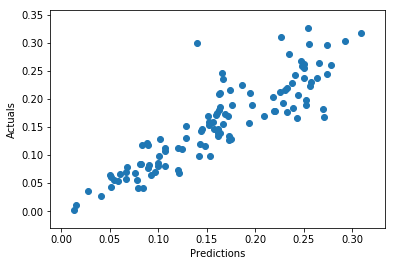

In [36]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predictions')
plt.ylabel('Actuals')

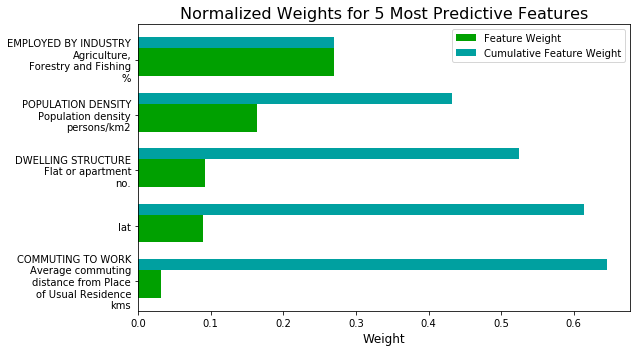

In [37]:
feature_plot_h(best_rf.feature_importances_, X_train, 5)

### Evaluate the results

In [40]:
r2_score(y_pred, y_test)

0.7450639301341384

An R2 of 0.745 is phenomenal! But a lot of importance is definitely coming from the first few features. 

## Feature refinement

With so many features I'm a little concerned about overlap, so to check this let's cut the features used for modelling back to just the top 75 (remembering the original set had ~450).

In [41]:
#Keep only top 75 features
indices = np.argsort(best_rf.feature_importances_)[::-1]
columns = X_train.columns.values[indices[75:]]

drop_cols = list(columns)
X_train_Refined = X_train.copy()
X_train_Refined.drop(drop_cols, axis=1, inplace=True)
X_train_Refined.head()

,,,REGISTERED MOTOR VEHICLES - NUMBER BY TYPE OF VEHICLE Heavy rigid trucks no.,REGISTERED MOTOR VEHICLES - NUMBER BY TYPE OF VEHICLE Articulated trucks no.,"EMPLOYED BY INDUSTRY Agriculture, Forestry and Fishing %",EMPLOYED BY INDUSTRY Manufacturing %,"EMPLOYED BY INDUSTRY Electricity, Gas, Water & Waste Services %",EMPLOYED BY INDUSTRY Wholesale Trade %,EMPLOYED BY INDUSTRY Retail Trade %,EMPLOYED BY INDUSTRY Financial & Insurance Services %,EMPLOYED BY INDUSTRY Education & Training %,"PERSONS WITH POST SCHOOL QUALIFICATIONS Advanced Diploma, or Diploma %",...,"ESTIMATED RESIDENT POPULATION (USUAL RESIDENTS, ERP AT 30 JUNE) Working Age Population (15-64 years) %",BIRTHS AND DEATHS Total Fertility Rate (per female) rate,POPULATION DENSITY Population density persons/km2,ABORIGINAL AND TORRES STRAIT ISLANDER PEOPLES Proportion of total population %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Born in North-West Europe %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Born in Southern & Eastern Europe %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Born in South-East Asia %,OVERSEAS BORN POPULATION (PROPORTION OF TOTAL POPULATION) Total Born Overseas %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,lat
CODE,LABEL,YEAR,,,,,,,,,,,,,,,,,,,,,
112011241,Evans Head,2016,83.0,46.0,6.0,7.9,1.2,1.6,10.0,1.3,10.2,6.9,...,58.7,1.9,9.8,4.5,3.3,0.2,0.5,6.6,2.8,-29.117409
126021591,Ryde,2016,64.0,2.0,0.1,5.0,0.6,4.8,9.3,6.9,7.5,9.8,...,68.8,1.6,3894.9,0.4,3.3,5.0,6.2,45.4,20.1,-33.801575
101021011,Queanbeyan Region,2016,404.0,33.0,2.7,3.2,1.0,1.5,6.2,1.3,7.9,10.9,...,67.5,1.9,5.7,2.0,6.3,1.5,0.8,13.0,2.6,-35.352466
116031315,Hassall Grove - Plumpton,2016,197.0,44.0,0.4,10.9,0.9,3.9,11.2,6.0,5.3,8.9,...,69.9,1.8,3435.0,2.6,1.7,2.2,15.5,42.8,10.1,-33.731667
125021477,Ermington - Rydalmere,2016,97.0,5.0,0.1,6.0,0.8,4.7,9.1,5.4,7.7,9.8,...,67.2,1.9,2233.7,0.9,3.3,2.4,4.7,39.9,14.1,-33.817674


In [42]:
rf = RandomForestRegressor(random_state=42)

parameters = {'n_estimators':[20,40,80,160],
              #'max_depth':[4,8,16,32,64],
              'min_samples_leaf':[1,2,3,4,5]
             }

# TODO: Make a scoring object using make_scorer()
scorer = make_scorer(r2_score)

# TODO: Perform grid search on the regressor using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(rf, param_grid=parameters, scoring=scorer, verbose = 2)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train_Refined, y_train)

# Get the estimator
best_rf = grid_fit.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.1s
[CV] min_samples_leaf=1, n_estimators=20 .............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.1s
[CV] min_samples_leaf=1, n_estimators=20 .............................
[CV] .............. min_samples_leaf=1, n_estimators=20, total=   0.1s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   0.2s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   0.2s
[CV] min_samples_leaf=1, n_estimators=40 .............................
[CV] .............. min_samples_leaf=1, n_estimators=40, total=   0.2s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   0.6s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .............. min_samples_leaf=1, n_estimators=80, total=   0.7s
[CV] min_samples_leaf=1, n_estimators=80 .............................
[CV] .

[CV] ............. min_samples_leaf=5, n_estimators=160, total=   0.8s


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   33.5s finished


In [43]:
# Make predictions using the unoptimized and model
y_pred = best_rf.predict(X_test.drop(drop_cols, axis=1))

In [44]:
best_rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

Text(0, 0.5, 'Actuals')

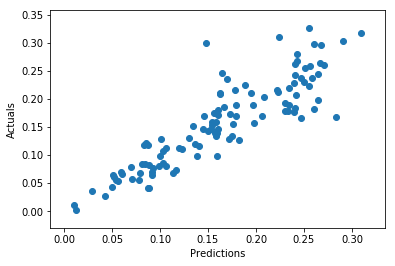

In [45]:
plt.scatter(y_pred, y_test)
plt.xlabel('Predictions')
plt.ylabel('Actuals')

In [46]:
r2_score(y_pred, y_test)

0.7439723980779221

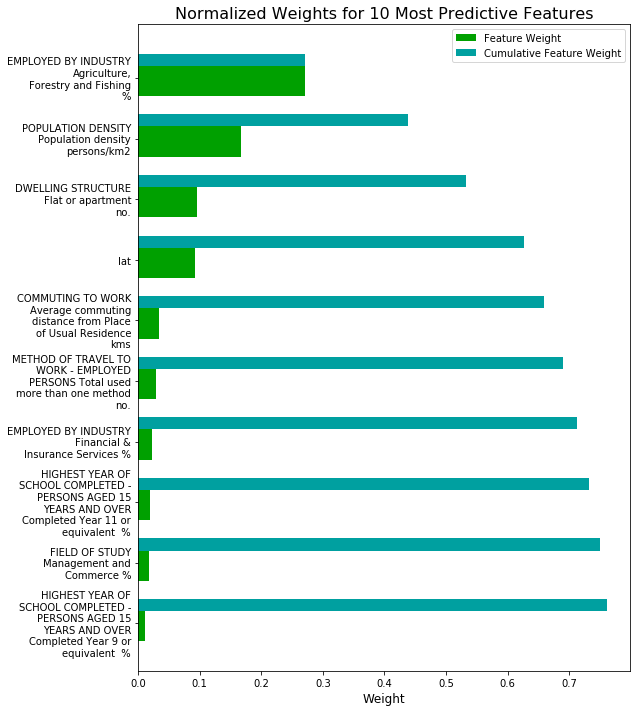

In [47]:
feature_plot_h(best_rf.feature_importances_, X_train.drop(drop_cols, axis=1), 10)

Just... wow! The R2 barely dropped at all, and our key features barely changed.

## Feature impact analysis - "Deploy"

But what do these features actually mean? If I increase population density does it decrease or increase solar panel installations (in line with the correlations above)? Or is it multi dimensional where it decreases then increases? By changing the values in the training set then re-predicting, we can model this out quite nicely.
 
I'm choosing to change the base values over a range of +/- the standard deviation of the original feature.

Note - I am choosing to reimport everything at this point for ease of jumping in and out of the workbook.

In [15]:
#Create X and y based on preprocessed data
X = pd.read_csv('{}\medians by code.csv'.format(nb_path), na_values='-', thousands=',')
X.rename(columns={'lat':'LATITUDE'}, inplace=True)
X.set_index(['CODE', 'LABEL', 'YEAR'], inplace=True)
y = X['Solar Per Household'].copy()
X.drop('Solar Per Household', axis=1, inplace=True)

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [16]:
# Initialise RF based on GridSearchCV parameters identified above
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

rf.fit(X_train, y_train)

# Make predictions using the model
y_pred = rf.predict(X_test)
r2_score(y_pred, y_test)

0.7450028827166401

In [17]:
#Keep only top 75 features
indices = np.argsort(rf.feature_importances_)[::-1]
worst_columns = list(X_train.columns.values[indices[75:]])

X_train_Refined = X_train.copy()
X_train_Refined.drop(worst_columns, axis=1, inplace=True)

In [18]:
# Initialise another RF based on GridSearchCV parameters identified above for the leaner dataset
lean_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=160, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

lean_rf.fit(X_train_Refined, y_train)

# Make predictions using the model
y_pred = lean_rf.predict(X_test.drop(worst_columns, axis=1))
r2_score(y_pred, y_test)

0.7441132579464321

# What are the main indicators of a region having an increased propensity to have solar panels installed?

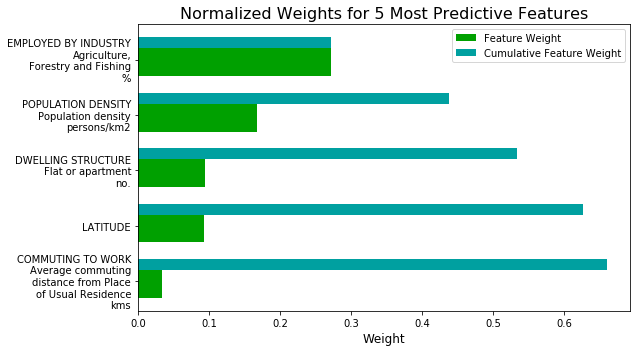

In [19]:
feature_plot_h(lean_rf.feature_importances_, X_train_Refined, 5)

# For these identified features, how do changes in the feature impact changes in solar panels installed?

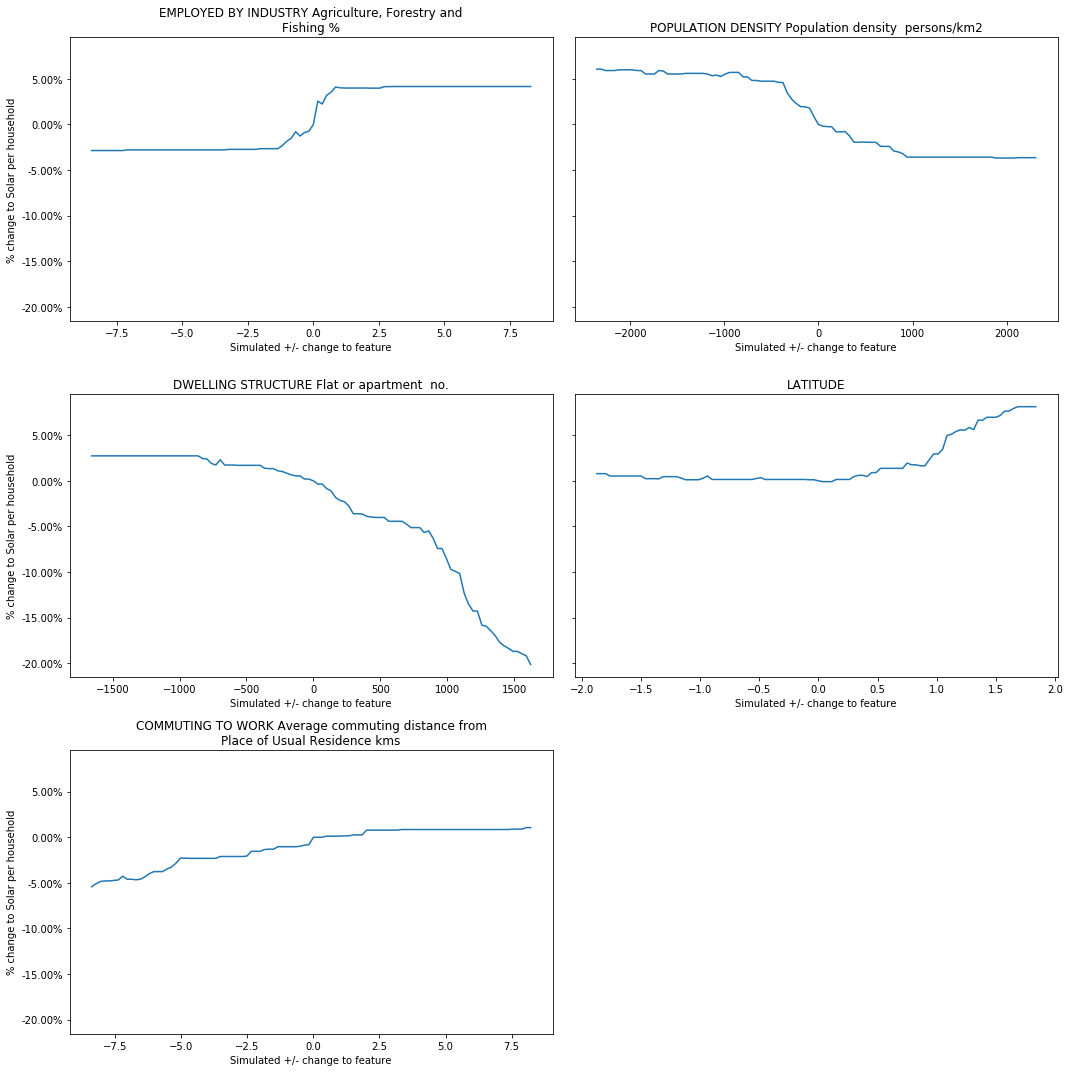

In [37]:
feature_impact_plot(lean_rf, X_train_Refined, 5, 'Solar per household')

# How have solar installations changed over time when using these features as categories?

First we'll have to reload the source data and get insight into which of these features actually *have* multi-year data. So re-run the first 7 cells in the notebook (no cleaning beyond this!).

After that I will break the features into quartiles and aggregate the data based on these features. Then plot the trend in gross installations over the timeframe available.

In [22]:
indices = np.argsort(lean_rf.feature_importances_)[::-1]
list(X_train_Refined.columns.values[indices[:5]])

['EMPLOYED BY INDUSTRY Agriculture, Forestry and Fishing %',
 'POPULATION DENSITY Population density  persons/km2',
 'DWELLING STRUCTURE Flat or apartment  no.',
 'LATITUDE',
 'COMMUTING TO WORK Average commuting distance from Place of Usual Residence kms']

In [29]:
top_features = list(X_train_Refined.columns.values[indices[:5]])

In [34]:
# Load all the files into a single df
df = pd.read_csv('{}\CSV\{}'.format(nb_path, files[0]), na_values='-', thousands=',')

for file in range(1,len(files)):
    df_temp = pd.read_csv('{}\CSV\{}'.format(nb_path, files[file]), na_values='-', thousands=',')
    df = pd.merge(df, df_temp, how='outer', left_on=['CODE','YEAR','LABEL'], right_on=['CODE','YEAR','LABEL'])

# Load in latitude and longitude data
df_temp = pd.read_csv('{}\latlng.csv'.format(nb_path), na_values='-', thousands=',')
df_temp.rename(columns = {df_temp.columns[0] : 'LABEL'}, inplace=True)
df = pd.merge(df, df_temp, how='inner', left_on='LABEL', right_on='LABEL')
df.rename(columns={'lat':'LATITUDE'}, inplace=True)

df['YEAR'].value_counts()

2015    579
2011    579
2018    579
2014    579
2017    579
2013    579
2016    579
2012    579
Name: YEAR, dtype: int64

In [37]:
df = remove_aggregation(df)
df.head()

,CODE,LABEL,YEAR,NUMBER OF BUSINESSES Number of non-employing businesses no.,NUMBER OF BUSINESSES 1-4 employees no.,NUMBER OF BUSINESSES 5-19 employees no.,NUMBER OF BUSINESSES 20 or more employees no.,NUMBER OF BUSINESSES Total number of businesses no.,BUSINESS ENTRIES Number of non-employing business entries no.,BUSINESS ENTRIES 1-4 employees no.,...,RELIGIOUS AFFILIATION Judaism %,RELIGIOUS AFFILIATION Other Religions %,"RELIGIOUS AFFILIATION Secular Beliefs, Other Spiritual Beliefs and No Religious Affiliation %",RELIGIOUS AFFILIATION Inadequately described or not stated %,AUSTRALIAN CITIZENSHIP Australian citizen %,AUSTRALIAN CITIZENSHIP Not an Australian citizen %,AUSTRALIAN CITIZENSHIP Australian Citizenship - Not stated %,SPEAKS A LANGUAGE OTHER THAN ENGLISH AT HOME Proportion of total population %,LATITUDE,long
8,101021009,Queanbeyan,2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,84.9,8.2,6.8,18.6,-35.352466,149.233725
9,101021009,Queanbeyan,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35.352466,149.233725
10,101021009,Queanbeyan,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35.352466,149.233725
11,101021009,Queanbeyan,2014,398.0,210.0,84.0,24.0,715.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35.352466,149.233725
12,101021009,Queanbeyan,2015,401.0,185.0,82.0,26.0,691.0,68.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-35.352466,149.233725


In [46]:
df.loc[:,['YEAR', solar]+top_features]

,YEAR,SOLAR INSTALLATIONS Small-Scale Solar Panel System Installations no.,"EMPLOYED BY INDUSTRY Agriculture, Forestry and Fishing %",POPULATION DENSITY Population density persons/km2,DWELLING STRUCTURE Flat or apartment no.,LATITUDE,COMMUTING TO WORK Average commuting distance from Place of Usual Residence kms
8,2011,NaN,0.2,NaN,1452.0,-35.352466,NaN
9,2012,NaN,NaN,2282.0,NaN,-35.352466,NaN
10,2013,NaN,NaN,2319.8,NaN,-35.352466,NaN
11,2014,425.0,NaN,2351.1,NaN,-35.352466,NaN
12,2015,485.0,NaN,2354.0,NaN,-35.352466,NaN
13,2016,548.0,0.2,2357.6,1564.0,-35.352466,10.7
14,2017,635.0,NaN,2383.0,NaN,-35.352466,NaN
15,2018,NaN,NaN,2405.4,NaN,-35.352466,NaN
24,2011,NaN,1.0,NaN,276.0,-33.285641,NaN
25,2012,NaN,NaN,566.5,NaN,-33.285641,NaN


So it looks like the only feature with data worth plotting as a key trend is 'Population density' over the course of 2014-2017, which to be honest is probably a great representative feature of the rest of the items anyway.   

First, plot histograms for these 4 years for the features, just to check quartile movement isn't too drastic.

In [93]:
pd.pivot_table(df.loc[:,['CODE','YEAR', solar]], values = solar, columns = 'YEAR', index = 'CODE').head()

YEAR,2014,2015,2016,2017
CODE,,,,
101021007,343.0,380.0,418.0,466.0
101021008,357.0,407.0,460.0,534.0
101021009,425.0,485.0,548.0,635.0
101021010,193.0,220.0,249.0,288.0
101021011,799.0,923.0,1027.0,1189.0


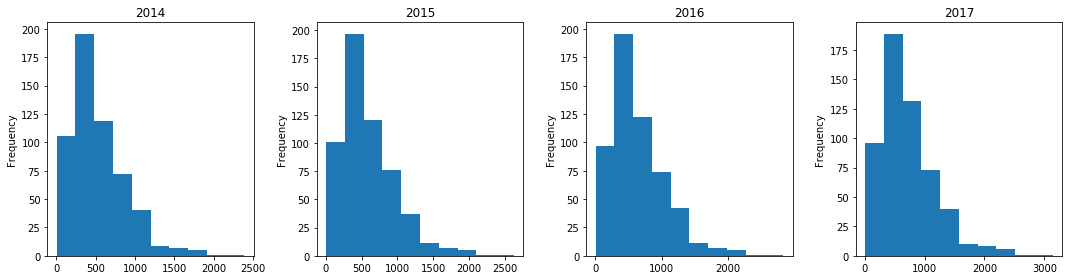

In [96]:
histo_plots(pd.pivot_table(df.loc[:,['CODE','YEAR', solar]], values = solar, columns = 'YEAR', index = 'CODE'),4)

In [109]:
metric = 'POPULATION DENSITY Population density  persons/km2'
pvt = pd.pivot_table(df.loc[:,['CODE','YEAR', metric]],
                     values = metric, columns = 'YEAR', index = 'CODE').drop([2012,2013,2018],axis=1)

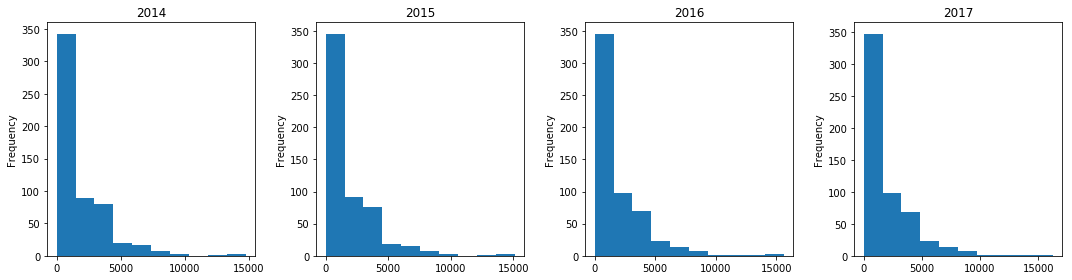

In [110]:
histo_plots(pvt, 4)

So while the distribution for solar panels changed significantly over time, the population density itself does not appear to have moved much. Which indicates first of all that population density is unlikely to be a causative factor in the purchase decision of solar panels over time, but it is a large indicator of the *propensity* to purchase. To further explore this, let's plot the trend after segregating the data into quartiles.

In [115]:
for col in pvt.columns:
    pvt['{} Quartile'.format(col)] = pd.qcut(pvt[col], 4, labels = ['q1','q2','q3','q4'])

pvt.head()

YEAR,2014,2015,2016,2017,2014 Quartile,2015 Quartile,2016 Quartile,2017 Quartile
CODE,,,,,,,,
101021007,1.1,1.1,1.2,1.2,q1,q1,q1,q1
101021008,1250.4,1232.1,1221.8,1215.0,q3,q3,q3,q3
101021009,2351.1,2354.0,2357.6,2383.0,q3,q3,q3,q3
101021010,382.0,381.5,382.2,385.7,q2,q2,q2,q2
101021011,5.2,5.4,5.7,6.0,q1,q1,q1,q1


In [117]:
df_temp = pd.pivot_table(df.loc[:,['CODE','YEAR', solar]],values = solar, columns = 'YEAR', index = 'CODE')
pvt = pd.merge(pvt, df_temp, how='inner', left_on='CODE', right_on='CODE')
pvt.head()

YEAR,2014_x,2015_x,2016_x,2017_x,2014 Quartile,2015 Quartile,2016 Quartile,2017 Quartile,2014_y,2015_y,2016_y,2017_y
CODE,,,,,,,,,,,,
101021007,1.1,1.1,1.2,1.2,q1,q1,q1,q1,343.0,380.0,418.0,466.0
101021008,1250.4,1232.1,1221.8,1215.0,q3,q3,q3,q3,357.0,407.0,460.0,534.0
101021009,2351.1,2354.0,2357.6,2383.0,q3,q3,q3,q3,425.0,485.0,548.0,635.0
101021010,382.0,381.5,382.2,385.7,q2,q2,q2,q2,193.0,220.0,249.0,288.0
101021011,5.2,5.4,5.7,6.0,q1,q1,q1,q1,799.0,923.0,1027.0,1189.0


In [120]:
year_list = ['2014_y','2015_y','2016_y','2017_y']
q_list = ['q1','q2','q3','q4']
pvt[pvt['2014 Quartile']=='q1']['2014_y'].sum()

q_summary = np.zeros((4,4))

for year in year_list:
    for q in q_list:
        q_summary[year_list.index(year), q_list.index(q)] = pvt[pvt[year.replace('_y',' Quartile')]==q][year].sum()

q_summary

array([[ 67191., 100468.,  75456.,  49956.],
       [ 77318., 111370.,  83925.,  53871.],
       [ 85728., 121468.,  89646.,  59114.],
       [ 97197., 137578.,  99123.,  65131.]])

In [127]:
df_qsum = pd.DataFrame(q_summary, index = [y.replace('_y','') for y in year_list], columns = q_list)
df_qsum

,q1,q2,q3,q4
2014,67191.0,100468.0,75456.0,49956.0
2015,77318.0,111370.0,83925.0,53871.0
2016,85728.0,121468.0,89646.0,59114.0
2017,97197.0,137578.0,99123.0,65131.0


In [211]:
df_qsum.div(df_qsum.sum(axis=1),axis=0)*100

,q1,q2,q3,q4
2014,22.926526,34.281113,25.746662,17.045699
2015,23.682018,34.111932,25.705701,16.500349
2016,24.083876,34.124442,25.184573,16.607109
2017,24.358380,34.478196,24.841052,16.322373


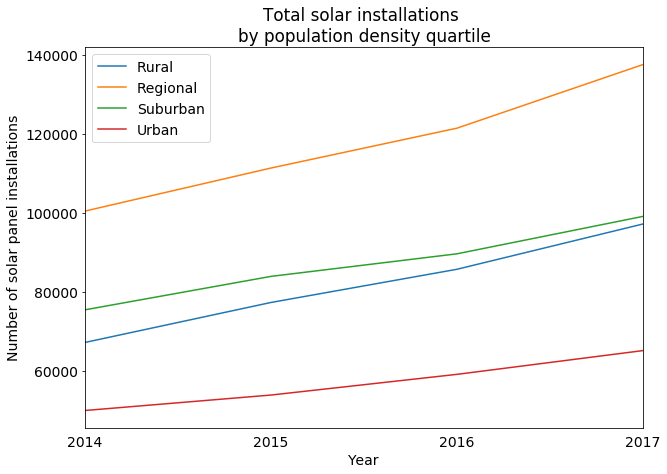

In [213]:
trend_plot = df_qsum.plot(figsize=(10,7))

trend_plot.set_title('Total solar installations \n'
                    + 'by population density quartile')
trend_plot.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are on
trend_plot.set_xlabel('Year')
trend_plot.set_ylabel('Number of solar panel installations')
plt.rcParams.update({'font.size': 14})

# Rename the legend features to make it a little less technical and more relatable to a general audience
trend_plot.legend(labels=['Rural','Regional','Suburban','Urban'])

In [148]:
# Calculate the total growth for each of the quartiles over the period 2014-2017
df_qsum.iloc[3,:]/df_qsum.iloc[0,:] - 1

q1    0.446578
q2    0.369371
q3    0.313653
q4    0.303767
dtype: float64

In [150]:
# Also get the CAGR
(df_qsum.iloc[3,:]/df_qsum.iloc[0,:])**(1/3) - 1

q1    0.130960
q2    0.110471
q3    0.095200
q4    0.092446
dtype: float64

## Further Insights

After exploring the data through a Random Forest model, both in feature importance and impact I can now see that a lot of the high correlations seen above were likely to have been artefacts of other correlated features. I.e. the immigrant populations could have been correlated with population density and dwelling structure, and thus by focusing on those two outputs their importance was not as high as originally featured.

I am very happy with my evaluation of the Random Forest model, delivering an R2 score of 0.745 is great.

By looking at the "Impacts" of changing values in these key features, it is interesting to notice the similarity to log probability functions for "Employed in agriculture, forestry and fishing%" and "population density" (and latitude when the bounds are pushed beyond standard deviation). Once you hit a certain level of people employed in these "non-urban" industries, you switch from a -2.5% impact on solar installations to a +4.5% - quite interesting.

I'm intrigued by the impact of Latitude on solar installations, as this is contrary to basic science indicating that solar has higher potential at lower latitutdes (closer to the equator) as nicely demonstrated [here](http://profhorn.meteor.wisc.edu/wxwise/radiation/sunangle.html). Whether it is a proxy for government intervention (subsidies and rebates at a state level), an indicator of higher electricty prices in the south, reflective of a more temperate climate meaning the effective yield is higher (due to fewer cloudy days), are all open questions for further exploration.

The above is all quite technical, so when it gets to cutting things into quartiles I'd better humanise it all a bit, by finding a representative "Town" for each of the quartiles to give a real human feel to what each area looks like.

In [175]:
pvt['2016 Quartile'].value_counts()

q4    141
q3    140
q2    140
q1    135
Name: 2016 Quartile, dtype: int64

In [203]:
# Get some region names from each of the quartiles
# Middle points
for q in q_list:
    code_ref = pvt[pvt['2016 Quartile']==q].sort_values('2016_x').reset_index().iloc[69,0]
    print(q, df[df['CODE'] == code_ref]['LABEL'].iloc[0])


q1 Junee
q2 Lennox Head - Skennars Head
q3 West Pennant Hills
q4 Lilyfield - Rozelle


In [206]:
# Get some region names from each of the quartiles
# end points
for q in q_list:
    code_ref = pvt[pvt['2016 Quartile']==q].sort_values('2016_x').reset_index().iloc[-1,0]
    print(q, df[df['CODE'] == code_ref]['LABEL'].iloc[0])


q1 Helensburgh
q2 Wagga Wagga - South
q3 Fairfield - East
q4 Potts Point - Woolloomooloo


## Based on the above, what insights would I share with key stakeholders to the solar industry (energy companies, governments, etc.) when considering future strategies?

For those in the business of supplying solar panels: it looks like the best market in Australia is outside the major cities, where population density is far lower and you have fewer apartment type structures. These areas are showing the strongest trends in growth in installations, and already represent around 60% of the total installations in Australia (meaning good business for those looking to leverage future maintenance opportunities).

From the view of the public sector, it looks like the market to-date is doing a good job of optimising for the population most likely to benefit from self-purchased solar installations:
1. Closer generation to the source means less transmission loss, so a net efficiency overall. 
2. Non-urban areas also benefit from installations due to the impact of "remoteness" on ability for power companies to quickly resolve maintenance issues.

Of course, the factor "Latitude" plays into this (and how closely it ties to state government incentives) may also be an indicator that the more "Southern" governments of New South Wales, Victoria and Tasmania are also doing a good job in further incentivising investment in this particular technology.

On the downside, housing trends are heading toward increased population density, and lower levels of home ownership. This means that continued progress to renewable goals will require investment outside of subsidising solar panel installation, and coming up with solutions relevant to and scaleable for urban populations.